In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [7]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

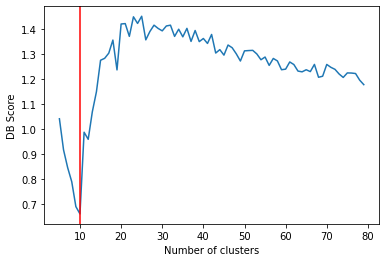

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [8]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

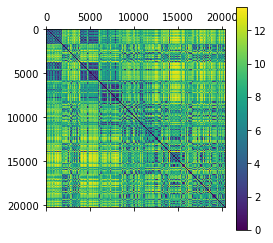

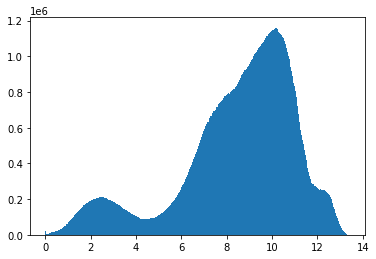

In [9]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

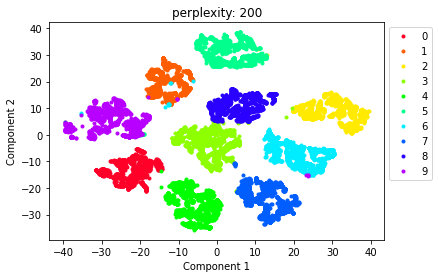

In [10]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [11]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [12]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [13]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [14]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [15]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9747203469176563


In [16]:
losses = []
accs = []
sparsity = []

In [17]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.5933701657458564
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7417127071823204
layer 6: 0.6489986187845305
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.292 | Reg loss: 0.016 | Tree loss: 2.292 | Accuracy: 0.091000 | 3.684 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.286 | Reg loss: 0.016 | Tree loss: 2.286 | Accuracy: 0.087500 | 1.998 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.272 | Reg loss: 0.016 | Tree loss: 2.272 | Accuracy: 0.258000 | 1.426 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.265 | Reg loss: 0.016 | Tree loss: 2.265 | Accuracy: 0.284500 | 1.137 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.255 | Reg loss: 0.016 | Tree loss: 2.255 | Accuracy: 0.302000 | 0.966 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.246 | Reg loss: 0.016 | Tree loss: 2.246 | Accuracy: 0.348500 | 0.852 sec/iter
Epoch: 00 | Batch: 006 / 

Epoch: 05 | Batch: 000 / 011 | Total loss: 2.204 | Reg loss: 0.016 | Tree loss: 2.204 | Accuracy: 0.363500 | 0.63 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.184 | Reg loss: 0.016 | Tree loss: 2.184 | Accuracy: 0.414000 | 0.623 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.160 | Reg loss: 0.017 | Tree loss: 2.160 | Accuracy: 0.416000 | 0.617 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.136 | Reg loss: 0.017 | Tree loss: 2.136 | Accuracy: 0.530500 | 0.61 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.120 | Reg loss: 0.017 | Tree loss: 2.120 | Accuracy: 0.503000 | 0.604 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.094 | Reg loss: 0.017 | Tree loss: 2.094 | Accuracy: 0.503000 | 0.597 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 2.078 | Reg loss: 0.017 | Tree loss: 2.078 | Accuracy: 0.479000 | 0.591 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 2.054 | Reg loss: 0.018 | Tree loss: 2.054 | Accuracy: 0.471000 | 0.585 sec/iter
Epoch: 05 

Epoch: 10 | Batch: 002 / 011 | Total loss: 1.983 | Reg loss: 0.020 | Tree loss: 1.983 | Accuracy: 0.535000 | 0.486 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.938 | Reg loss: 0.020 | Tree loss: 1.938 | Accuracy: 0.507000 | 0.484 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.894 | Reg loss: 0.020 | Tree loss: 1.894 | Accuracy: 0.510500 | 0.482 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.870 | Reg loss: 0.020 | Tree loss: 1.870 | Accuracy: 0.474500 | 0.479 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.835 | Reg loss: 0.021 | Tree loss: 1.835 | Accuracy: 0.484000 | 0.477 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.807 | Reg loss: 0.021 | Tree loss: 1.807 | Accuracy: 0.484500 | 0.475 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.800 | Reg loss: 0.021 | Tree loss: 1.800 | Accuracy: 0.475500 | 0.473 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.774 | Reg loss: 0.021 | Tree loss: 1.774 | Accuracy: 0.489000 | 0.471 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 1.710 | Reg loss: 0.023 | Tree loss: 1.710 | Accuracy: 0.511500 | 0.485 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.671 | Reg loss: 0.023 | Tree loss: 1.671 | Accuracy: 0.505000 | 0.483 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.634 | Reg loss: 0.023 | Tree loss: 1.634 | Accuracy: 0.525000 | 0.481 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.622 | Reg loss: 0.023 | Tree loss: 1.622 | Accuracy: 0.513500 | 0.48 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.600 | Reg loss: 0.023 | Tree loss: 1.600 | Accuracy: 0.530000 | 0.479 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 1.596 | Reg loss: 0.023 | Tree loss: 1.596 | Accuracy: 0.515000 | 0.477 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.560 | Reg loss: 0.024 | Tree loss: 1.560 | Accuracy: 0.505119 | 0.476 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0

Epoch: 20 | Batch: 006 / 011 | Total loss: 1.498 | Reg loss: 0.025 | Tree loss: 1.498 | Accuracy: 0.518500 | 0.526 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 1.463 | Reg loss: 0.025 | Tree loss: 1.463 | Accuracy: 0.519500 | 0.525 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 1.468 | Reg loss: 0.025 | Tree loss: 1.468 | Accuracy: 0.521500 | 0.524 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 1.439 | Reg loss: 0.025 | Tree loss: 1.439 | Accuracy: 0.541500 | 0.523 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 1.427 | Reg loss: 0.025 | Tree loss: 1.427 | Accuracy: 0.484642 | 0.522 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.705 | Reg loss: 0.024 | Tree loss: 1.705 | Accuracy: 0.505500 | 0.533 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 008 / 011 | Total loss: 1.372 | Reg loss: 0.026 | Tree loss: 1.372 | Accuracy: 0.516500 | 0.546 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 1.366 | Reg loss: 0.026 | Tree loss: 1.366 | Accuracy: 0.524500 | 0.545 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 1.357 | Reg loss: 0.026 | Tree loss: 1.357 | Accuracy: 0.484642 | 0.544 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.593 | Reg loss: 0.025 | Tree loss: 1.593 | Accuracy: 0.523500 | 0.546 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 1.550 | Reg loss: 0.025 | Tree loss: 1.550 | Accuracy: 0.557500 | 0.545 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 1.504 | Reg loss: 0.025 | Tree loss: 1.504 | Accuracy: 0.559000 | 0.544 sec/iter
Epoch: 26 | Batch: 00

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 1.496 | Reg loss: 0.026 | Tree loss: 1.496 | Accuracy: 0.519500 | 0.534 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 1.438 | Reg loss: 0.026 | Tree loss: 1.438 | Accuracy: 0.547500 | 0.534 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 1.399 | Reg loss: 0.026 | Tree loss: 1.399 | Accuracy: 0.571000 | 0.533 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 1.373 | Reg loss: 0.026 | Tree loss: 1.373 | Accuracy: 0.540000 | 0.532 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 1.321 | Reg loss: 0.026 | Tree loss: 1.321 | Accuracy: 0.551000 | 0.531 sec/iter
Epoch: 31 | Batch: 005 / 011 | Total loss: 1.303 | Reg loss: 0.026 | Tree loss: 1.303 | Accuracy: 0.518000 | 0.53 sec/iter
Epoch: 31 | Batch: 006

layer 6: 0.9723756906077349
Epoch: 36 | Batch: 000 / 011 | Total loss: 1.379 | Reg loss: 0.026 | Tree loss: 1.379 | Accuracy: 0.565500 | 0.524 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 1.364 | Reg loss: 0.026 | Tree loss: 1.364 | Accuracy: 0.564500 | 0.524 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 1.334 | Reg loss: 0.026 | Tree loss: 1.334 | Accuracy: 0.546000 | 0.523 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 1.302 | Reg loss: 0.026 | Tree loss: 1.302 | Accuracy: 0.536000 | 0.522 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 1.265 | Reg loss: 0.026 | Tree loss: 1.265 | Accuracy: 0.524000 | 0.522 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 1.237 | Reg loss: 0.026 | Tree loss: 1.237 | Accuracy: 0.536500 | 0.521 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 1.219 | Reg loss: 0.026 | Tree loss: 1.219 | Accuracy: 0.530500 | 0.52 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 1.234 | Reg loss: 0.026 | Tree loss: 1.234 | Accuracy: 0.51600

Epoch: 41 | Batch: 002 / 011 | Total loss: 1.271 | Reg loss: 0.026 | Tree loss: 1.271 | Accuracy: 0.563500 | 0.517 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 1.242 | Reg loss: 0.026 | Tree loss: 1.242 | Accuracy: 0.539500 | 0.516 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 1.206 | Reg loss: 0.026 | Tree loss: 1.206 | Accuracy: 0.543500 | 0.515 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 1.190 | Reg loss: 0.026 | Tree loss: 1.190 | Accuracy: 0.526000 | 0.515 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 1.186 | Reg loss: 0.026 | Tree loss: 1.186 | Accuracy: 0.539500 | 0.514 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 1.178 | Reg loss: 0.026 | Tree loss: 1.178 | Accuracy: 0.532000 | 0.513 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 1.178 | Reg loss: 0.026 | Tree loss: 1.178 | Accuracy: 0.536500 | 0.513 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 1.172 | Reg loss: 0.026 | Tree loss: 1.172 | Accuracy: 0.542000 | 0.512 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 1.161 | Reg loss: 0.026 | Tree loss: 1.161 | Accuracy: 0.542500 | 0.536 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 1.174 | Reg loss: 0.026 | Tree loss: 1.174 | Accuracy: 0.510500 | 0.535 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 1.144 | Reg loss: 0.026 | Tree loss: 1.144 | Accuracy: 0.534500 | 0.535 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 1.132 | Reg loss: 0.026 | Tree loss: 1.132 | Accuracy: 0.547000 | 0.534 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 1.137 | Reg loss: 0.026 | Tree loss: 1.137 | Accuracy: 0.532500 | 0.534 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 1.119 | Reg loss: 0.026 | Tree loss: 1.119 | Accuracy: 0.548500 | 0.533 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 1.173 | Reg loss: 0.026 | Tree loss: 1.173 | Accuracy: 0.515358 | 0.533 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 51 | Batch: 006 / 011 | Total loss: 1.113 | Reg loss: 0.026 | Tree loss: 1.113 | Accuracy: 0.534000 | 0.537 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 1.121 | Reg loss: 0.026 | Tree loss: 1.121 | Accuracy: 0.525500 | 0.537 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 1.110 | Reg loss: 0.026 | Tree loss: 1.110 | Accuracy: 0.536500 | 0.536 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 1.082 | Reg loss: 0.026 | Tree loss: 1.082 | Accuracy: 0.543000 | 0.535 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 1.084 | Reg loss: 0.026 | Tree loss: 1.084 | Accuracy: 0.573379 | 0.535 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 1.212 | Reg loss: 0.026 | Tree loss: 1.212 | Accuracy: 0.586500 | 0.54 sec/iter
Epoch: 52 | Batch: 001

Epoch: 56 | Batch: 008 / 011 | Total loss: 1.074 | Reg loss: 0.026 | Tree loss: 1.074 | Accuracy: 0.574000 | 0.529 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 1.065 | Reg loss: 0.026 | Tree loss: 1.065 | Accuracy: 0.565000 | 0.528 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 1.065 | Reg loss: 0.026 | Tree loss: 1.065 | Accuracy: 0.552901 | 0.528 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 1.175 | Reg loss: 0.026 | Tree loss: 1.175 | Accuracy: 0.633500 | 0.534 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 1.150 | Reg loss: 0.026 | Tree loss: 1.150 | Accuracy: 0.625500 | 0.533 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 1.133 | Reg loss: 0.026 | Tree loss: 1.133 | Accuracy: 0.601000 | 0.533 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 1.062 | Reg loss: 0.026 | Tree loss: 1.062 | Accuracy: 0.597270 | 0.523 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 1.162 | Reg loss: 0.026 | Tree loss: 1.162 | Accuracy: 0.637000 | 0.527 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 1.131 | Reg loss: 0.026 | Tree loss: 1.131 | Accuracy: 0.657000 | 0.527 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 1.102 | Reg loss: 0.026 | Tree loss: 1.102 | Accuracy: 0.628500 | 0.526 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.100 | Reg loss: 0.026 | Tree loss: 1.100 | Accuracy: 0.593500 | 0.526 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.065 | Reg loss: 0.026 | Tree loss: 1.065 | Accuracy: 0.618000 | 0.525 sec/iter
Epoch: 62 | Batch: 00

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.111 | Reg loss: 0.026 | Tree loss: 1.111 | Accuracy: 0.664000 | 0.531 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.105 | Reg loss: 0.026 | Tree loss: 1.105 | Accuracy: 0.661500 | 0.53 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.087 | Reg loss: 0.026 | Tree loss: 1.087 | Accuracy: 0.639000 | 0.53 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.035 | Reg loss: 0.026 | Tree loss: 1.035 | Accuracy: 0.656000 | 0.53 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.049 | Reg loss: 0.026 | Tree loss: 1.049 | Accuracy: 0.602500 | 0.529 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.050 | Reg loss: 0.026 | Tree loss: 1.050 | Accuracy: 0.584500 | 0.529 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.018 | Reg loss: 0.026 | Tree loss: 1.018 | Accuracy: 0.603500 | 0.528 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.040 | Reg loss: 0.026 | Tree loss: 1.040 | Accuracy: 0.585500 | 0.528 sec/iter
Epoch: 67 |

Epoch: 72 | Batch: 002 / 011 | Total loss: 1.066 | Reg loss: 0.026 | Tree loss: 1.066 | Accuracy: 0.641500 | 0.539 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.042 | Reg loss: 0.026 | Tree loss: 1.042 | Accuracy: 0.650000 | 0.539 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.048 | Reg loss: 0.026 | Tree loss: 1.048 | Accuracy: 0.627500 | 0.539 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 1.018 | Reg loss: 0.026 | Tree loss: 1.018 | Accuracy: 0.626000 | 0.538 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 1.011 | Reg loss: 0.026 | Tree loss: 1.011 | Accuracy: 0.612500 | 0.538 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.987 | Reg loss: 0.026 | Tree loss: 0.987 | Accuracy: 0.636500 | 0.538 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 1.005 | Reg loss: 0.026 | Tree loss: 1.005 | Accuracy: 0.607500 | 0.537 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.993 | Reg loss: 0.026 | Tree loss: 0.993 | Accuracy: 0.639000 | 0.537 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 1.000 | Reg loss: 0.026 | Tree loss: 1.000 | Accuracy: 0.633000 | 0.537 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 1.006 | Reg loss: 0.026 | Tree loss: 1.006 | Accuracy: 0.626000 | 0.536 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 1.012 | Reg loss: 0.026 | Tree loss: 1.012 | Accuracy: 0.637000 | 0.536 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.994 | Reg loss: 0.026 | Tree loss: 0.994 | Accuracy: 0.630000 | 0.536 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.981 | Reg loss: 0.026 | Tree loss: 0.981 | Accuracy: 0.632500 | 0.535 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.973 | Reg loss: 0.026 | Tree loss: 0.973 | Accuracy: 0.621000 | 0.535 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.045 | Reg loss: 0.026 | Tree loss: 1.045 | Accuracy: 0.631399 | 0.534 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 006 / 011 | Total loss: 0.960 | Reg loss: 0.026 | Tree loss: 0.960 | Accuracy: 0.646000 | 0.532 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 0.991 | Reg loss: 0.026 | Tree loss: 0.991 | Accuracy: 0.600000 | 0.531 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.985 | Reg loss: 0.026 | Tree loss: 0.985 | Accuracy: 0.612500 | 0.531 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.990 | Reg loss: 0.026 | Tree loss: 0.990 | Accuracy: 0.609000 | 0.531 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 1.002 | Reg loss: 0.026 | Tree loss: 1.002 | Accuracy: 0.634812 | 0.53 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 1.026 | Reg loss: 0.026 | Tree loss: 1.026 | Accuracy: 0.658000 | 0.532 sec/iter
Epoch: 83 | Batch: 001

Epoch: 87 | Batch: 008 / 011 | Total loss: 0.940 | Reg loss: 0.026 | Tree loss: 0.940 | Accuracy: 0.638000 | 0.528 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.954 | Reg loss: 0.026 | Tree loss: 0.954 | Accuracy: 0.636500 | 0.527 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.941 | Reg loss: 0.026 | Tree loss: 0.941 | Accuracy: 0.651877 | 0.527 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 1.027 | Reg loss: 0.026 | Tree loss: 1.027 | Accuracy: 0.631000 | 0.531 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.026 | Tree loss: 1.019 | Accuracy: 0.653000 | 0.531 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 1.008 | Reg loss: 0.026 | Tree loss: 1.008 | Accuracy: 0.650000 | 0.531 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 0.895 | Reg loss: 0.026 | Tree loss: 0.895 | Accuracy: 0.655290 | 0.536 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 1.043 | Reg loss: 0.026 | Tree loss: 1.043 | Accuracy: 0.596000 | 0.541 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.026 | Tree loss: 0.999 | Accuracy: 0.641500 | 0.541 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.968 | Reg loss: 0.026 | Tree loss: 0.968 | Accuracy: 0.655000 | 0.54 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.968 | Reg loss: 0.026 | Tree loss: 0.968 | Accuracy: 0.623500 | 0.54 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.928 | Reg loss: 0.026 | Tree loss: 0.928 | Accuracy: 0.676000 | 0.54 sec/iter
Epoch: 93 | Batch: 005 /

Epoch: 98 | Batch: 000 / 011 | Total loss: 1.006 | Reg loss: 0.026 | Tree loss: 1.006 | Accuracy: 0.632500 | 0.538 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 1.001 | Reg loss: 0.026 | Tree loss: 1.001 | Accuracy: 0.609000 | 0.538 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.979 | Reg loss: 0.026 | Tree loss: 0.979 | Accuracy: 0.626000 | 0.538 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.965 | Reg loss: 0.026 | Tree loss: 0.965 | Accuracy: 0.654500 | 0.538 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.925 | Reg loss: 0.026 | Tree loss: 0.925 | Accuracy: 0.678000 | 0.537 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.906 | Reg loss: 0.026 | Tree loss: 0.906 | Accuracy: 0.680500 | 0.537 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.942 | Reg loss: 0.026 | Tree loss: 0.942 | Accuracy: 0.642500 | 0.537 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.026 | Tree loss: 0.924 | Accuracy: 0.652000 | 0.536 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 0.955 | Reg loss: 0.026 | Tree loss: 0.955 | Accuracy: 0.672500 | 0.535 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.963 | Reg loss: 0.026 | Tree loss: 0.963 | Accuracy: 0.631000 | 0.534 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.932 | Reg loss: 0.026 | Tree loss: 0.932 | Accuracy: 0.676000 | 0.534 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.922 | Reg loss: 0.026 | Tree loss: 0.922 | Accuracy: 0.647000 | 0.534 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.918 | Reg loss: 0.026 | Tree loss: 0.918 | Accuracy: 0.642500 | 0.534 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.026 | Tree loss: 0.932 | Accuracy: 0.640000 | 0.533 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.918 | Reg loss: 0.026 | Tree loss: 0.918 | Accuracy: 0.644500 | 0.533 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.878 | Reg loss: 0.026 | Tree loss: 0.878 | Accuracy: 0.670500 | 0.533 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.026 | Tree loss: 0.936 | Accuracy: 0.667500 | 0.534 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.916 | Reg loss: 0.026 | Tree loss: 0.916 | Accuracy: 0.664000 | 0.533 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.938 | Reg loss: 0.026 | Tree loss: 0.938 | Accuracy: 0.658500 | 0.533 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.936 | Reg loss: 0.026 | Tree loss: 0.936 | Accuracy: 0.641000 | 0.533 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.925 | Reg loss: 0.026 | Tree loss: 0.925 | Accuracy: 0.639500 | 0.533 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.874 | Accuracy: 0.658000 | 0.532 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.699659 | 0.532 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 113 | Batch: 006 / 011 | Total loss: 0.904 | Reg loss: 0.026 | Tree loss: 0.904 | Accuracy: 0.663000 | 0.533 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.907 | Reg loss: 0.026 | Tree loss: 0.907 | Accuracy: 0.648000 | 0.533 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.894 | Reg loss: 0.027 | Tree loss: 0.894 | Accuracy: 0.653000 | 0.533 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.894 | Reg loss: 0.027 | Tree loss: 0.894 | Accuracy: 0.650000 | 0.532 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.871 | Reg loss: 0.027 | Tree loss: 0.871 | Accuracy: 0.672355 | 0.532 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 1.004 | Reg loss: 0.026 | Tree loss: 1.004 | Accuracy: 0.612500 | 0.536 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.893 | Reg loss: 0.027 | Tree loss: 0.893 | Accuracy: 0.658500 | 0.539 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.910 | Reg loss: 0.027 | Tree loss: 0.910 | Accuracy: 0.645000 | 0.538 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.870 | Reg loss: 0.027 | Tree loss: 0.870 | Accuracy: 0.645051 | 0.538 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.989 | Reg loss: 0.027 | Tree loss: 0.989 | Accuracy: 0.609000 | 0.539 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.987 | Reg loss: 0.027 | Tree loss: 0.987 | Accuracy: 0.611500 | 0.539 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.938 | Reg loss: 0.027 | Tree loss: 0.938 | Accuracy: 0.656500 | 0.539 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.874 | Reg loss: 0.027 | Tree loss: 0.874 | Accuracy: 0.645051 | 0.536 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.965 | Reg loss: 0.027 | Tree loss: 0.965 | Accuracy: 0.625500 | 0.538 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.980 | Reg loss: 0.027 | Tree loss: 0.980 | Accuracy: 0.617000 | 0.538 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.942 | Reg loss: 0.027 | Tree loss: 0.942 | Accuracy: 0.646000 | 0.538 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.893 | Reg loss: 0.027 | Tree loss: 0.893 | Accuracy: 0.667500 | 0.537 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.899 | Reg loss: 0.027 | Tree loss: 0.899 | Accuracy: 0.660500 | 0.537 sec/iter
Epoch: 124 | Ba

layer 6: 0.9723756906077349
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.955 | Reg loss: 0.027 | Tree loss: 0.955 | Accuracy: 0.631500 | 0.538 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.940 | Reg loss: 0.027 | Tree loss: 0.940 | Accuracy: 0.643000 | 0.538 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.935 | Reg loss: 0.027 | Tree loss: 0.935 | Accuracy: 0.649000 | 0.538 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.915 | Reg loss: 0.027 | Tree loss: 0.915 | Accuracy: 0.673000 | 0.537 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.894 | Reg loss: 0.027 | Tree loss: 0.894 | Accuracy: 0.680500 | 0.537 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.898 | Reg loss: 0.027 | Tree loss: 0.898 | Accuracy: 0.676000 | 0.537 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.896 | Reg loss: 0.027 | Tree loss: 0.896 | Accuracy: 0.659500 | 0.537 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy

Epoch: 134 | Batch: 001 / 011 | Total loss: 0.935 | Reg loss: 0.027 | Tree loss: 0.935 | Accuracy: 0.645000 | 0.535 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.935 | Reg loss: 0.027 | Tree loss: 0.935 | Accuracy: 0.633000 | 0.535 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.902 | Reg loss: 0.027 | Tree loss: 0.902 | Accuracy: 0.658500 | 0.535 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.890 | Reg loss: 0.027 | Tree loss: 0.890 | Accuracy: 0.675000 | 0.535 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.890 | Reg loss: 0.027 | Tree loss: 0.890 | Accuracy: 0.677500 | 0.535 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.876 | Reg loss: 0.027 | Tree loss: 0.876 | Accuracy: 0.680000 | 0.534 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.877 | Reg loss: 0.027 | Tree loss: 0.877 | Accuracy: 0.668000 | 0.534 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.860 | Reg loss: 0.027 | Tree loss: 0.860 | Accuracy: 0.671000 | 0.534 sec/iter


Epoch: 139 | Batch: 003 / 011 | Total loss: 0.888 | Reg loss: 0.027 | Tree loss: 0.888 | Accuracy: 0.670000 | 0.541 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.901 | Reg loss: 0.027 | Tree loss: 0.901 | Accuracy: 0.661500 | 0.54 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.864 | Reg loss: 0.027 | Tree loss: 0.864 | Accuracy: 0.684000 | 0.54 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.845 | Reg loss: 0.027 | Tree loss: 0.845 | Accuracy: 0.692500 | 0.54 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.903 | Reg loss: 0.027 | Tree loss: 0.903 | Accuracy: 0.653500 | 0.54 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.878 | Reg loss: 0.027 | Tree loss: 0.878 | Accuracy: 0.662500 | 0.54 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.659000 | 0.54 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.837 | Reg loss: 0.027 | Tree loss: 0.837 | Accuracy: 0.699659 | 0.539 sec/iter
Averag

Epoch: 144 | Batch: 005 / 011 | Total loss: 0.846 | Reg loss: 0.027 | Tree loss: 0.846 | Accuracy: 0.689500 | 0.538 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.027 | Tree loss: 0.868 | Accuracy: 0.674500 | 0.538 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.853 | Reg loss: 0.027 | Tree loss: 0.853 | Accuracy: 0.669500 | 0.538 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.659500 | 0.538 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.872 | Reg loss: 0.027 | Tree loss: 0.872 | Accuracy: 0.660500 | 0.538 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.911 | Reg loss: 0.027 | Tree loss: 0.911 | Accuracy: 0.641638 | 0.537 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Ba

Epoch: 149 | Batch: 007 / 011 | Total loss: 0.834 | Reg loss: 0.027 | Tree loss: 0.834 | Accuracy: 0.677000 | 0.537 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.875 | Reg loss: 0.027 | Tree loss: 0.875 | Accuracy: 0.646500 | 0.536 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.852 | Reg loss: 0.027 | Tree loss: 0.852 | Accuracy: 0.670500 | 0.536 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.877 | Reg loss: 0.027 | Tree loss: 0.877 | Accuracy: 0.679181 | 0.536 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.928 | Reg loss: 0.027 | Tree loss: 0.928 | Accuracy: 0.651500 | 0.538 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.923 | Reg loss: 0.027 | Tree loss: 0.923 | Accuracy: 0.648500 | 0.538 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 009 / 011 | Total loss: 0.856 | Reg loss: 0.027 | Tree loss: 0.856 | Accuracy: 0.673500 | 0.535 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 0.854 | Reg loss: 0.027 | Tree loss: 0.854 | Accuracy: 0.679181 | 0.535 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.948 | Reg loss: 0.027 | Tree loss: 0.948 | Accuracy: 0.642500 | 0.535 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.907 | Reg loss: 0.027 | Tree loss: 0.907 | Accuracy: 0.642000 | 0.535 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.905 | Reg loss: 0.027 | Tree loss: 0.905 | Accuracy: 0.658000 | 0.535 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.863 | Reg loss: 0.027 | Tree loss: 0.863 | Accuracy: 0.691000 | 0.535 sec/iter
Epoch: 155 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.924 | Reg loss: 0.027 | Tree loss: 0.924 | Accuracy: 0.660000 | 0.538 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.914 | Reg loss: 0.027 | Tree loss: 0.914 | Accuracy: 0.654000 | 0.538 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.879 | Reg loss: 0.027 | Tree loss: 0.879 | Accuracy: 0.678000 | 0.537 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.690000 | 0.537 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.686000 | 0.537 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.850 | Reg loss: 0.027 | Tree loss: 0.850 | Accuracy: 0.701000 | 0.537 sec/iter
Epoch: 160 | Ba

layer 6: 0.9723756906077349
Epoch: 165 | Batch: 000 / 011 | Total loss: 0.918 | Reg loss: 0.027 | Tree loss: 0.918 | Accuracy: 0.655000 | 0.537 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.916 | Reg loss: 0.027 | Tree loss: 0.916 | Accuracy: 0.651000 | 0.537 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.891 | Reg loss: 0.027 | Tree loss: 0.891 | Accuracy: 0.676000 | 0.537 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.879 | Reg loss: 0.027 | Tree loss: 0.879 | Accuracy: 0.689000 | 0.537 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.713000 | 0.537 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.705000 | 0.536 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.733000 | 0.536 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy

Epoch: 170 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.027 | Tree loss: 0.894 | Accuracy: 0.658500 | 0.535 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.854 | Reg loss: 0.027 | Tree loss: 0.854 | Accuracy: 0.705000 | 0.535 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.709000 | 0.535 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.706000 | 0.535 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.715000 | 0.534 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.845 | Reg loss: 0.028 | Tree loss: 0.845 | Accuracy: 0.705500 | 0.534 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.844 | Reg loss: 0.028 | Tree loss: 0.844 | Accuracy: 0.716500 | 0.534 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.710000 | 0.534 sec/iter


Epoch: 175 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.719000 | 0.535 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.705000 | 0.535 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.711500 | 0.535 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.721500 | 0.534 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.695500 | 0.534 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.709500 | 0.534 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.675768 | 0.534 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 180 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.743000 | 0.534 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.730500 | 0.533 sec/iter
Epoch: 180 | Batch: 008 / 011 | Total loss: 0.829 | Reg loss: 0.028 | Tree loss: 0.829 | Accuracy: 0.714500 | 0.533 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.728000 | 0.533 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.842 | Reg loss: 0.028 | Tree loss: 0.842 | Accuracy: 0.703072 | 0.533 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 0.900 | Reg loss: 0.028 | Tree loss: 0.900 | Accuracy: 0.653500 | 0.533 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 008 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.723500 | 0.533 sec/iter
Epoch: 185 | Batch: 009 / 011 | Total loss: 0.849 | Reg loss: 0.028 | Tree loss: 0.849 | Accuracy: 0.704500 | 0.533 sec/iter
Epoch: 185 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.740614 | 0.533 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.899 | Reg loss: 0.028 | Tree loss: 0.899 | Accuracy: 0.661500 | 0.534 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.897 | Reg loss: 0.028 | Tree loss: 0.897 | Accuracy: 0.659000 | 0.534 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 0.877 | Reg loss: 0.028 | Tree loss: 0.877 | Accuracy: 0.676500 | 0.533 sec/iter
Epoch: 186 | Ba

Epoch: 190 | Batch: 010 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.730375 | 0.53 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 191 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.028 | Tree loss: 0.888 | Accuracy: 0.664500 | 0.531 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.897 | Reg loss: 0.028 | Tree loss: 0.897 | Accuracy: 0.663000 | 0.531 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.028 | Tree loss: 0.864 | Accuracy: 0.676500 | 0.531 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.854 | Reg loss: 0.028 | Tree loss: 0.854 | Accuracy: 0.703000 | 0.531 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.719000 | 0.53 sec/iter
Epoch: 191 | Batc

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.887 | Reg loss: 0.028 | Tree loss: 0.887 | Accuracy: 0.674500 | 0.533 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.886 | Reg loss: 0.028 | Tree loss: 0.886 | Accuracy: 0.670000 | 0.532 sec/iter
Epoch: 196 | Batch: 002 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.674000 | 0.532 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.028 | Tree loss: 0.860 | Accuracy: 0.679000 | 0.532 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.715000 | 0.532 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.698500 | 0.532 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.722000 | 0.532 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total los

Epoch: 201 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.028 | Tree loss: 0.904 | Accuracy: 0.645000 | 0.532 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.857 | Reg loss: 0.028 | Tree loss: 0.857 | Accuracy: 0.682500 | 0.532 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.838 | Reg loss: 0.028 | Tree loss: 0.838 | Accuracy: 0.700000 | 0.532 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.706000 | 0.532 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.832 | Reg loss: 0.028 | Tree loss: 0.832 | Accuracy: 0.713500 | 0.532 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.718000 | 0.531 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.750500 | 0.531 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.729000 | 0.531 sec/iter


Epoch: 206 | Batch: 003 / 011 | Total loss: 0.866 | Reg loss: 0.028 | Tree loss: 0.866 | Accuracy: 0.687000 | 0.532 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.725000 | 0.532 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.028 | Tree loss: 0.823 | Accuracy: 0.718000 | 0.531 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.750000 | 0.531 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.708000 | 0.531 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.848 | Reg loss: 0.028 | Tree loss: 0.848 | Accuracy: 0.700000 | 0.531 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.721000 | 0.531 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.713311 | 0.531 sec/iter


Epoch: 211 | Batch: 005 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.693000 | 0.53 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.728500 | 0.53 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.731000 | 0.529 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.727000 | 0.529 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.717000 | 0.529 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.716724 | 0.529 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batc

Epoch: 216 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.713500 | 0.53 sec/iter
Epoch: 216 | Batch: 008 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.719500 | 0.53 sec/iter
Epoch: 216 | Batch: 009 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.729500 | 0.53 sec/iter
Epoch: 216 | Batch: 010 / 011 | Total loss: 0.738 | Reg loss: 0.028 | Tree loss: 0.738 | Accuracy: 0.761092 | 0.53 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.919 | Reg loss: 0.028 | Tree loss: 0.919 | Accuracy: 0.655500 | 0.531 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.028 | Tree loss: 0.873 | Accuracy: 0.670000 | 0.531 sec/iter
Epoch: 217 | Batch:

Epoch: 221 | Batch: 009 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.739000 | 0.531 sec/iter
Epoch: 221 | Batch: 010 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.754266 | 0.531 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 222 | Batch: 000 / 011 | Total loss: 0.908 | Reg loss: 0.028 | Tree loss: 0.908 | Accuracy: 0.642000 | 0.533 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.899 | Reg loss: 0.028 | Tree loss: 0.899 | Accuracy: 0.656000 | 0.532 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.847 | Reg loss: 0.028 | Tree loss: 0.847 | Accuracy: 0.695500 | 0.532 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.718500 | 0.532 sec/iter
Epoch: 222 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 227 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.028 | Tree loss: 0.894 | Accuracy: 0.652500 | 0.53 sec/iter
Epoch: 227 | Batch: 001 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.673000 | 0.53 sec/iter
Epoch: 227 | Batch: 002 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.706000 | 0.53 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.699500 | 0.53 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.829 | Reg loss: 0.028 | Tree loss: 0.829 | Accuracy: 0.709500 | 0.53 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 0.817 | Reg loss: 0.028 | Tree loss: 0.817 | Accuracy: 0.722500 | 0.53 sec/iter
Epoch: 227 | Batch: 0

Epoch: 232 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.028 | Tree loss: 0.876 | Accuracy: 0.652000 | 0.53 sec/iter
Epoch: 232 | Batch: 001 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.678000 | 0.53 sec/iter
Epoch: 232 | Batch: 002 / 011 | Total loss: 0.878 | Reg loss: 0.028 | Tree loss: 0.878 | Accuracy: 0.658000 | 0.53 sec/iter
Epoch: 232 | Batch: 003 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.696500 | 0.53 sec/iter
Epoch: 232 | Batch: 004 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.723000 | 0.53 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.718500 | 0.53 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.728500 | 0.529 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.738000 | 0.529 sec/iter
Epoch:

Epoch: 237 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.680500 | 0.529 sec/iter
Epoch: 237 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.681500 | 0.529 sec/iter
Epoch: 237 | Batch: 004 / 011 | Total loss: 0.832 | Reg loss: 0.028 | Tree loss: 0.832 | Accuracy: 0.705000 | 0.529 sec/iter
Epoch: 237 | Batch: 005 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.725000 | 0.528 sec/iter
Epoch: 237 | Batch: 006 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.721000 | 0.528 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.718500 | 0.528 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.730000 | 0.528 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.714500 | 0.528 sec/iter


Epoch: 242 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.687000 | 0.53 sec/iter
Epoch: 242 | Batch: 005 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.723500 | 0.53 sec/iter
Epoch: 242 | Batch: 006 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.739500 | 0.53 sec/iter
Epoch: 242 | Batch: 007 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.722500 | 0.53 sec/iter
Epoch: 242 | Batch: 008 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.751500 | 0.53 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.721000 | 0.53 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.737201 | 0.529 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3:

Epoch: 247 | Batch: 006 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.752500 | 0.527 sec/iter
Epoch: 247 | Batch: 007 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.721500 | 0.527 sec/iter
Epoch: 247 | Batch: 008 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.737000 | 0.527 sec/iter
Epoch: 247 | Batch: 009 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.737000 | 0.527 sec/iter
Epoch: 247 | Batch: 010 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.726962 | 0.526 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 0.884 | Reg loss: 0.028 | Tree loss: 0.884 | Accuracy: 0.673500 | 0.528 sec/iter
Epoch: 248 | Ba

Epoch: 252 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.716000 | 0.524 sec/iter
Epoch: 252 | Batch: 009 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.718000 | 0.524 sec/iter
Epoch: 252 | Batch: 010 / 011 | Total loss: 0.773 | Reg loss: 0.028 | Tree loss: 0.773 | Accuracy: 0.709898 | 0.524 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 253 | Batch: 000 / 011 | Total loss: 0.867 | Reg loss: 0.028 | Tree loss: 0.867 | Accuracy: 0.683500 | 0.525 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 0.890 | Reg loss: 0.028 | Tree loss: 0.890 | Accuracy: 0.659500 | 0.525 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.683000 | 0.525 sec/iter
Epoch: 253 | Ba

Epoch: 257 | Batch: 010 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.740614 | 0.523 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 258 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.028 | Tree loss: 0.876 | Accuracy: 0.673500 | 0.525 sec/iter
Epoch: 258 | Batch: 001 / 011 | Total loss: 0.856 | Reg loss: 0.028 | Tree loss: 0.856 | Accuracy: 0.668000 | 0.525 sec/iter
Epoch: 258 | Batch: 002 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.694000 | 0.525 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.028 | Tree loss: 0.842 | Accuracy: 0.692500 | 0.524 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.712000 | 0.524 sec/iter
Epoch: 258 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 263 | Batch: 000 / 011 | Total loss: 0.870 | Reg loss: 0.028 | Tree loss: 0.870 | Accuracy: 0.678000 | 0.525 sec/iter
Epoch: 263 | Batch: 001 / 011 | Total loss: 0.871 | Reg loss: 0.028 | Tree loss: 0.871 | Accuracy: 0.664500 | 0.524 sec/iter
Epoch: 263 | Batch: 002 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.682500 | 0.524 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.028 | Tree loss: 0.833 | Accuracy: 0.691500 | 0.524 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.719500 | 0.524 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.717500 | 0.524 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.719500 | 0.524 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.813 | Reg loss: 0.028 |

Epoch: 268 | Batch: 001 / 011 | Total loss: 0.875 | Reg loss: 0.028 | Tree loss: 0.875 | Accuracy: 0.675500 | 0.522 sec/iter
Epoch: 268 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.684500 | 0.521 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.713500 | 0.521 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.721000 | 0.521 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.710000 | 0.521 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.730500 | 0.521 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.779 | Reg loss: 0.028 | Tree loss: 0.779 | Accuracy: 0.737000 | 0.521 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.727500 | 0.521 sec/iter


Epoch: 273 | Batch: 003 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.702000 | 0.519 sec/iter
Epoch: 273 | Batch: 004 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.724500 | 0.519 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.696500 | 0.519 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.735000 | 0.519 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.730000 | 0.519 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.774 | Reg loss: 0.028 | Tree loss: 0.774 | Accuracy: 0.742500 | 0.519 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.718500 | 0.519 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.838 | Reg loss: 0.028 | Tree loss: 0.838 | Accuracy: 0.706485 | 0.519 sec/iter


Epoch: 278 | Batch: 005 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.729000 | 0.518 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.710000 | 0.518 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.740000 | 0.518 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.779 | Reg loss: 0.028 | Tree loss: 0.779 | Accuracy: 0.734000 | 0.518 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.723000 | 0.518 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 0.728 | Reg loss: 0.028 | Tree loss: 0.728 | Accuracy: 0.781570 | 0.518 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 279 | Ba

Epoch: 283 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.705000 | 0.518 sec/iter
Epoch: 283 | Batch: 008 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.740500 | 0.518 sec/iter
Epoch: 283 | Batch: 009 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.712500 | 0.518 sec/iter
Epoch: 283 | Batch: 010 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.730375 | 0.518 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 284 | Batch: 000 / 011 | Total loss: 0.897 | Reg loss: 0.028 | Tree loss: 0.897 | Accuracy: 0.643000 | 0.52 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.677000 | 0.519 sec/iter
Epoch: 284 | Bat

Epoch: 288 | Batch: 009 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.738000 | 0.517 sec/iter
Epoch: 288 | Batch: 010 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.723549 | 0.517 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 289 | Batch: 000 / 011 | Total loss: 0.882 | Reg loss: 0.028 | Tree loss: 0.882 | Accuracy: 0.665500 | 0.517 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.659500 | 0.517 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.028 | Tree loss: 0.854 | Accuracy: 0.679500 | 0.517 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.835 | Reg loss: 0.028 | Tree loss: 0.835 | Accuracy: 0.696500 | 0.517 sec/iter
Epoch: 289 | Ba

layer 6: 0.9723756906077349
Epoch: 294 | Batch: 000 / 011 | Total loss: 0.907 | Reg loss: 0.028 | Tree loss: 0.907 | Accuracy: 0.639000 | 0.516 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.028 | Tree loss: 0.865 | Accuracy: 0.671000 | 0.516 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.674500 | 0.516 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.694000 | 0.516 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.721000 | 0.516 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.715500 | 0.516 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.743000 | 0.515 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy

Epoch: 299 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.028 | Tree loss: 0.873 | Accuracy: 0.658000 | 0.517 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.674500 | 0.517 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.832 | Reg loss: 0.028 | Tree loss: 0.832 | Accuracy: 0.717000 | 0.516 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.028 | Tree loss: 0.849 | Accuracy: 0.678500 | 0.516 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.721500 | 0.516 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.734000 | 0.516 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.727500 | 0.516 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.727000 | 0.516 sec/iter


Epoch: 304 | Batch: 003 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.711000 | 0.517 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.721500 | 0.517 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.704500 | 0.517 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.740500 | 0.517 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.726500 | 0.516 sec/iter
Epoch: 304 | Batch: 008 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.734000 | 0.516 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.717000 | 0.516 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 0.849 | Reg loss: 0.028 | Tree loss: 0.849 | Accuracy: 0.703072 | 0.516 sec/iter


Epoch: 309 | Batch: 005 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.711000 | 0.515 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.736000 | 0.514 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.716000 | 0.514 sec/iter
Epoch: 309 | Batch: 008 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.725500 | 0.514 sec/iter
Epoch: 309 | Batch: 009 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.727000 | 0.514 sec/iter
Epoch: 309 | Batch: 010 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.720137 | 0.514 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 310 | Ba

Epoch: 314 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.714000 | 0.513 sec/iter
Epoch: 314 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.735500 | 0.513 sec/iter
Epoch: 314 | Batch: 009 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.726000 | 0.513 sec/iter
Epoch: 314 | Batch: 010 / 011 | Total loss: 0.750 | Reg loss: 0.028 | Tree loss: 0.750 | Accuracy: 0.747440 | 0.513 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 315 | Batch: 000 / 011 | Total loss: 0.875 | Reg loss: 0.028 | Tree loss: 0.875 | Accuracy: 0.669000 | 0.513 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.700500 | 0.513 sec/iter
Epoch: 315 | Ba

Epoch: 319 | Batch: 009 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.718500 | 0.514 sec/iter
Epoch: 319 | Batch: 010 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.713311 | 0.514 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 320 | Batch: 000 / 011 | Total loss: 0.869 | Reg loss: 0.028 | Tree loss: 0.869 | Accuracy: 0.667500 | 0.514 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.677000 | 0.514 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.028 | Tree loss: 0.860 | Accuracy: 0.676000 | 0.513 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.677500 | 0.513 sec/iter
Epoch: 320 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 325 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.028 | Tree loss: 0.878 | Accuracy: 0.654500 | 0.514 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.867 | Reg loss: 0.028 | Tree loss: 0.867 | Accuracy: 0.670000 | 0.514 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.700500 | 0.514 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.710500 | 0.514 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.715500 | 0.514 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.717500 | 0.513 sec/iter
Epoch: 325 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 330 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.028 | Tree loss: 0.865 | Accuracy: 0.680000 | 0.513 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 0.871 | Reg loss: 0.028 | Tree loss: 0.871 | Accuracy: 0.668500 | 0.513 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.670500 | 0.513 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.698000 | 0.513 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.712000 | 0.513 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.705000 | 0.513 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.718000 | 0.513 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.790 | Reg loss: 0.028 |

Epoch: 335 | Batch: 001 / 011 | Total loss: 0.861 | Reg loss: 0.028 | Tree loss: 0.861 | Accuracy: 0.667000 | 0.512 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.028 | Tree loss: 0.849 | Accuracy: 0.686000 | 0.511 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.705500 | 0.511 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.706500 | 0.511 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.708000 | 0.511 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.728000 | 0.511 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.720000 | 0.511 sec/iter
Epoch: 335 | Batch: 008 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.730000 | 0.511 sec/iter


Epoch: 340 | Batch: 003 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.707000 | 0.513 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.724500 | 0.513 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.703500 | 0.512 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.739500 | 0.512 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.714500 | 0.512 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.721500 | 0.512 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.719500 | 0.512 sec/iter
Epoch: 340 | Batch: 010 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.720137 | 0.512 sec/iter


Epoch: 345 | Batch: 005 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.711000 | 0.513 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.724500 | 0.512 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.715500 | 0.512 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.717500 | 0.512 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.726000 | 0.512 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.744027 | 0.512 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 346 | Ba

Epoch: 350 | Batch: 007 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.741500 | 0.511 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.731500 | 0.511 sec/iter
Epoch: 350 | Batch: 009 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.706500 | 0.511 sec/iter
Epoch: 350 | Batch: 010 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.716724 | 0.511 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 351 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.028 | Tree loss: 0.876 | Accuracy: 0.664500 | 0.512 sec/iter
Epoch: 351 | Batch: 001 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.678000 | 0.512 sec/iter
Epoch: 351 | Ba

Epoch: 355 | Batch: 009 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.735500 | 0.511 sec/iter
Epoch: 355 | Batch: 010 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.740614 | 0.511 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 356 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.028 | Tree loss: 0.893 | Accuracy: 0.649000 | 0.511 sec/iter
Epoch: 356 | Batch: 001 / 011 | Total loss: 0.881 | Reg loss: 0.028 | Tree loss: 0.881 | Accuracy: 0.670500 | 0.511 sec/iter
Epoch: 356 | Batch: 002 / 011 | Total loss: 0.826 | Reg loss: 0.028 | Tree loss: 0.826 | Accuracy: 0.688000 | 0.511 sec/iter
Epoch: 356 | Batch: 003 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.697000 | 0.51 sec/iter
Epoch: 356 | Bat

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 361 | Batch: 000 / 011 | Total loss: 0.859 | Reg loss: 0.028 | Tree loss: 0.859 | Accuracy: 0.671500 | 0.511 sec/iter
Epoch: 361 | Batch: 001 / 011 | Total loss: 0.848 | Reg loss: 0.028 | Tree loss: 0.848 | Accuracy: 0.668500 | 0.511 sec/iter
Epoch: 361 | Batch: 002 / 011 | Total loss: 0.833 | Reg loss: 0.028 | Tree loss: 0.833 | Accuracy: 0.689500 | 0.511 sec/iter
Epoch: 361 | Batch: 003 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.717500 | 0.511 sec/iter
Epoch: 361 | Batch: 004 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.724000 | 0.511 sec/iter
Epoch: 361 | Batch: 005 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.695000 | 0.511 sec/iter
Epoch: 361 | Ba

layer 6: 0.9723756906077349
Epoch: 366 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.028 | Tree loss: 0.876 | Accuracy: 0.662500 | 0.511 sec/iter
Epoch: 366 | Batch: 001 / 011 | Total loss: 0.871 | Reg loss: 0.028 | Tree loss: 0.871 | Accuracy: 0.681000 | 0.511 sec/iter
Epoch: 366 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.701000 | 0.511 sec/iter
Epoch: 366 | Batch: 003 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.692500 | 0.511 sec/iter
Epoch: 366 | Batch: 004 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.734500 | 0.511 sec/iter
Epoch: 366 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.712000 | 0.511 sec/iter
Epoch: 366 | Batch: 006 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.728000 | 0.511 sec/iter
Epoch: 366 | Batch: 007 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy

Epoch: 371 | Batch: 002 / 011 | Total loss: 0.828 | Reg loss: 0.028 | Tree loss: 0.828 | Accuracy: 0.701000 | 0.51 sec/iter
Epoch: 371 | Batch: 003 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.700500 | 0.51 sec/iter
Epoch: 371 | Batch: 004 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.716500 | 0.51 sec/iter
Epoch: 371 | Batch: 005 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.715500 | 0.51 sec/iter
Epoch: 371 | Batch: 006 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.744500 | 0.51 sec/iter
Epoch: 371 | Batch: 007 / 011 | Total loss: 0.764 | Reg loss: 0.028 | Tree loss: 0.764 | Accuracy: 0.744000 | 0.51 sec/iter
Epoch: 371 | Batch: 008 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.738000 | 0.509 sec/iter
Epoch: 371 | Batch: 009 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.720500 | 0.509 sec/iter
Epoch:

Epoch: 376 | Batch: 004 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.713500 | 0.509 sec/iter
Epoch: 376 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.708500 | 0.509 sec/iter
Epoch: 376 | Batch: 006 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.710500 | 0.509 sec/iter
Epoch: 376 | Batch: 007 / 011 | Total loss: 0.779 | Reg loss: 0.028 | Tree loss: 0.779 | Accuracy: 0.716000 | 0.509 sec/iter
Epoch: 376 | Batch: 008 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.721500 | 0.509 sec/iter
Epoch: 376 | Batch: 009 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.724500 | 0.508 sec/iter
Epoch: 376 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.696246 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 381 | Batch: 006 / 011 | Total loss: 0.774 | Reg loss: 0.028 | Tree loss: 0.774 | Accuracy: 0.755000 | 0.51 sec/iter
Epoch: 381 | Batch: 007 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.733000 | 0.51 sec/iter
Epoch: 381 | Batch: 008 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.736000 | 0.51 sec/iter
Epoch: 381 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.717000 | 0.51 sec/iter
Epoch: 381 | Batch: 010 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.726962 | 0.51 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 382 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.028 | Tree loss: 0.883 | Accuracy: 0.670000 | 0.51 sec/iter
Epoch: 382 | Batch: 0

Epoch: 386 | Batch: 008 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.723000 | 0.509 sec/iter
Epoch: 386 | Batch: 009 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.733000 | 0.509 sec/iter
Epoch: 386 | Batch: 010 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.757679 | 0.509 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 387 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.028 | Tree loss: 0.883 | Accuracy: 0.659000 | 0.51 sec/iter
Epoch: 387 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.028 | Tree loss: 0.870 | Accuracy: 0.662000 | 0.509 sec/iter
Epoch: 387 | Batch: 002 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.683500 | 0.509 sec/iter
Epoch: 387 | Bat

Epoch: 391 | Batch: 010 / 011 | Total loss: 0.764 | Reg loss: 0.028 | Tree loss: 0.764 | Accuracy: 0.757679 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 392 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.028 | Tree loss: 0.868 | Accuracy: 0.665000 | 0.509 sec/iter
Epoch: 392 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.028 | Tree loss: 0.868 | Accuracy: 0.661500 | 0.509 sec/iter
Epoch: 392 | Batch: 002 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.685000 | 0.508 sec/iter
Epoch: 392 | Batch: 003 / 011 | Total loss: 0.822 | Reg loss: 0.028 | Tree loss: 0.822 | Accuracy: 0.696500 | 0.508 sec/iter
Epoch: 392 | Batch: 004 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.711000 | 0.508 sec/iter
Epoch: 392 | Ba

Epoch: 397 | Batch: 000 / 011 | Total loss: 0.874 | Reg loss: 0.028 | Tree loss: 0.874 | Accuracy: 0.667500 | 0.508 sec/iter
Epoch: 397 | Batch: 001 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.673000 | 0.508 sec/iter
Epoch: 397 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.708000 | 0.508 sec/iter
Epoch: 397 | Batch: 003 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.707500 | 0.508 sec/iter
Epoch: 397 | Batch: 004 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.729000 | 0.508 sec/iter
Epoch: 397 | Batch: 005 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.705500 | 0.508 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.712000 | 0.508 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.727500 | 0.508 sec/iter


Epoch: 402 | Batch: 002 / 011 | Total loss: 0.871 | Reg loss: 0.028 | Tree loss: 0.871 | Accuracy: 0.657500 | 0.51 sec/iter
Epoch: 402 | Batch: 003 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.701000 | 0.51 sec/iter
Epoch: 402 | Batch: 004 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.703500 | 0.509 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.722500 | 0.509 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.727000 | 0.509 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.750500 | 0.509 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.712000 | 0.509 sec/iter
Epoch: 402 | Batch: 009 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.714500 | 0.509 sec/iter
Ep

Epoch: 407 | Batch: 004 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.715000 | 0.508 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.723000 | 0.508 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.737000 | 0.508 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.717000 | 0.508 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.740000 | 0.508 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.717000 | 0.508 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.703072 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 412 | Batch: 006 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.714000 | 0.508 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.747500 | 0.508 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.732000 | 0.508 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.734500 | 0.508 sec/iter
Epoch: 412 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.686007 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 413 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.028 | Tree loss: 0.878 | Accuracy: 0.662500 | 0.508 sec/iter
Epoch: 413 | Ba

Epoch: 417 | Batch: 008 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.739500 | 0.508 sec/iter
Epoch: 417 | Batch: 009 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.741000 | 0.508 sec/iter
Epoch: 417 | Batch: 010 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.709898 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 418 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.028 | Tree loss: 0.873 | Accuracy: 0.663000 | 0.509 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.028 | Tree loss: 0.847 | Accuracy: 0.671500 | 0.509 sec/iter
Epoch: 418 | Batch: 002 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.695500 | 0.509 sec/iter
Epoch: 418 | Ba

Epoch: 422 | Batch: 010 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.747440 | 0.509 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 423 | Batch: 000 / 011 | Total loss: 0.871 | Reg loss: 0.028 | Tree loss: 0.871 | Accuracy: 0.667500 | 0.509 sec/iter
Epoch: 423 | Batch: 001 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.673500 | 0.509 sec/iter
Epoch: 423 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.028 | Tree loss: 0.848 | Accuracy: 0.685000 | 0.509 sec/iter
Epoch: 423 | Batch: 003 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.715000 | 0.509 sec/iter
Epoch: 423 | Batch: 004 / 011 | Total loss: 0.808 | Reg loss: 0.028 | Tree loss: 0.808 | Accuracy: 0.710500 | 0.509 sec/iter
Epoch: 423 | Ba

layer 6: 0.9723756906077349
Epoch: 428 | Batch: 000 / 011 | Total loss: 0.884 | Reg loss: 0.028 | Tree loss: 0.884 | Accuracy: 0.664500 | 0.509 sec/iter
Epoch: 428 | Batch: 001 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.678500 | 0.508 sec/iter
Epoch: 428 | Batch: 002 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.676000 | 0.508 sec/iter
Epoch: 428 | Batch: 003 / 011 | Total loss: 0.843 | Reg loss: 0.028 | Tree loss: 0.843 | Accuracy: 0.684500 | 0.508 sec/iter
Epoch: 428 | Batch: 004 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.707000 | 0.508 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.730000 | 0.508 sec/iter
Epoch: 428 | Batch: 006 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.723000 | 0.508 sec/iter
Epoch: 428 | Batch: 007 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy

Epoch: 433 | Batch: 001 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.675000 | 0.508 sec/iter
Epoch: 433 | Batch: 002 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.707000 | 0.508 sec/iter
Epoch: 433 | Batch: 003 / 011 | Total loss: 0.823 | Reg loss: 0.028 | Tree loss: 0.823 | Accuracy: 0.699000 | 0.508 sec/iter
Epoch: 433 | Batch: 004 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.726000 | 0.508 sec/iter
Epoch: 433 | Batch: 005 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.728000 | 0.508 sec/iter
Epoch: 433 | Batch: 006 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.735000 | 0.507 sec/iter
Epoch: 433 | Batch: 007 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.734500 | 0.507 sec/iter
Epoch: 433 | Batch: 008 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.733500 | 0.507 sec/iter


Epoch: 438 | Batch: 003 / 011 | Total loss: 0.824 | Reg loss: 0.028 | Tree loss: 0.824 | Accuracy: 0.694000 | 0.508 sec/iter
Epoch: 438 | Batch: 004 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.712500 | 0.508 sec/iter
Epoch: 438 | Batch: 005 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.723500 | 0.508 sec/iter
Epoch: 438 | Batch: 006 / 011 | Total loss: 0.771 | Reg loss: 0.028 | Tree loss: 0.771 | Accuracy: 0.735500 | 0.508 sec/iter
Epoch: 438 | Batch: 007 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.733500 | 0.508 sec/iter
Epoch: 438 | Batch: 008 / 011 | Total loss: 0.766 | Reg loss: 0.028 | Tree loss: 0.766 | Accuracy: 0.742000 | 0.508 sec/iter
Epoch: 438 | Batch: 009 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.739500 | 0.508 sec/iter
Epoch: 438 | Batch: 010 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.703072 | 0.507 sec/iter


Epoch: 443 | Batch: 005 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.707000 | 0.508 sec/iter
Epoch: 443 | Batch: 006 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.731000 | 0.507 sec/iter
Epoch: 443 | Batch: 007 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.747500 | 0.507 sec/iter
Epoch: 443 | Batch: 008 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.735000 | 0.507 sec/iter
Epoch: 443 | Batch: 009 / 011 | Total loss: 0.771 | Reg loss: 0.028 | Tree loss: 0.771 | Accuracy: 0.738000 | 0.507 sec/iter
Epoch: 443 | Batch: 010 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.709898 | 0.507 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 444 | Ba

Epoch: 448 | Batch: 007 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.725500 | 0.507 sec/iter
Epoch: 448 | Batch: 008 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.743000 | 0.507 sec/iter
Epoch: 448 | Batch: 009 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.733000 | 0.507 sec/iter
Epoch: 448 | Batch: 010 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.737201 | 0.507 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 449 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.028 | Tree loss: 0.894 | Accuracy: 0.645000 | 0.507 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.671500 | 0.507 sec/iter
Epoch: 449 | Ba

Epoch: 453 | Batch: 009 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.724000 | 0.506 sec/iter
Epoch: 453 | Batch: 010 / 011 | Total loss: 0.732 | Reg loss: 0.028 | Tree loss: 0.732 | Accuracy: 0.757679 | 0.506 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.872 | Reg loss: 0.028 | Tree loss: 0.872 | Accuracy: 0.668500 | 0.507 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.673000 | 0.507 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.694000 | 0.507 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.028 | Tree loss: 0.842 | Accuracy: 0.672500 | 0.507 sec/iter
Epoch: 454 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 459 | Batch: 000 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.684500 | 0.507 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.839 | Reg loss: 0.028 | Tree loss: 0.839 | Accuracy: 0.676000 | 0.507 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.028 | Tree loss: 0.883 | Accuracy: 0.669500 | 0.507 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.669500 | 0.507 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.701500 | 0.507 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.701000 | 0.507 sec/iter
Epoch: 459 | Ba

Epoch: 464 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.028 | Tree loss: 0.883 | Accuracy: 0.651000 | 0.506 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 0.875 | Reg loss: 0.028 | Tree loss: 0.875 | Accuracy: 0.659500 | 0.506 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.855 | Reg loss: 0.028 | Tree loss: 0.855 | Accuracy: 0.669500 | 0.506 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.722500 | 0.506 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.713500 | 0.506 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.717000 | 0.506 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.719500 | 0.506 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.738000 | 0.506 sec/iter


Epoch: 469 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.678500 | 0.506 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.710500 | 0.506 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.695500 | 0.506 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.695000 | 0.506 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.735500 | 0.506 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.727500 | 0.506 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.732000 | 0.506 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.712000 | 0.506 sec/iter


Epoch: 474 | Batch: 004 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.727000 | 0.506 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.701000 | 0.506 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.717000 | 0.506 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.779 | Reg loss: 0.028 | Tree loss: 0.779 | Accuracy: 0.738500 | 0.506 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.707000 | 0.506 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.736000 | 0.506 sec/iter
Epoch: 474 | Batch: 010 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.720137 | 0.506 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 479 | Batch: 006 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.728000 | 0.507 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.028 | Tree loss: 0.763 | Accuracy: 0.754500 | 0.507 sec/iter
Epoch: 479 | Batch: 008 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.730000 | 0.507 sec/iter
Epoch: 479 | Batch: 009 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.715500 | 0.507 sec/iter
Epoch: 479 | Batch: 010 / 011 | Total loss: 0.717 | Reg loss: 0.028 | Tree loss: 0.717 | Accuracy: 0.761092 | 0.507 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 480 | Batch: 000 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree loss: 0.862 | Accuracy: 0.664500 | 0.507 sec/iter
Epoch: 480 | Ba

Epoch: 484 | Batch: 008 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.720500 | 0.506 sec/iter
Epoch: 484 | Batch: 009 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.716000 | 0.506 sec/iter
Epoch: 484 | Batch: 010 / 011 | Total loss: 0.742 | Reg loss: 0.028 | Tree loss: 0.742 | Accuracy: 0.723549 | 0.506 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 485 | Batch: 000 / 011 | Total loss: 0.866 | Reg loss: 0.028 | Tree loss: 0.866 | Accuracy: 0.681000 | 0.507 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.028 | Tree loss: 0.870 | Accuracy: 0.670500 | 0.506 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree loss: 0.813 | Accuracy: 0.703500 | 0.506 sec/iter
Epoch: 485 | Ba

Epoch: 489 | Batch: 010 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.703072 | 0.505 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 490 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.028 | Tree loss: 0.873 | Accuracy: 0.654500 | 0.505 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.680000 | 0.505 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.696000 | 0.505 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 0.829 | Reg loss: 0.028 | Tree loss: 0.829 | Accuracy: 0.688500 | 0.505 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.724000 | 0.505 sec/iter
Epoch: 490 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 495 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.028 | Tree loss: 0.883 | Accuracy: 0.660000 | 0.507 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.672000 | 0.507 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.688000 | 0.507 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.683500 | 0.507 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.689500 | 0.507 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.699000 | 0.507 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.738500 | 0.507 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 0.776 | Reg loss: 0.028 |

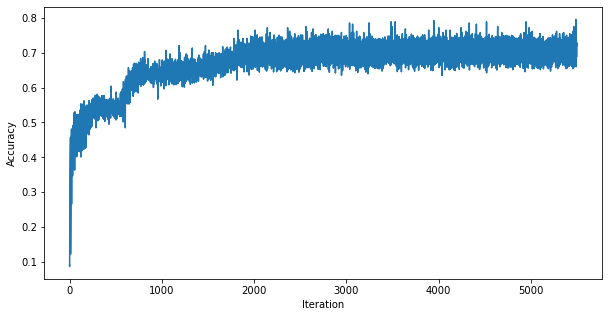

In [18]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

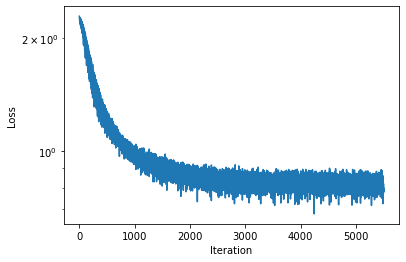

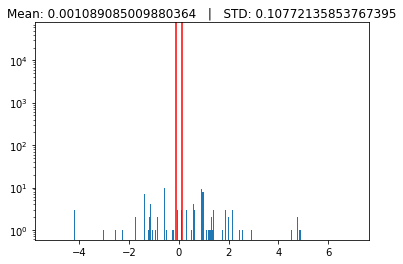

In [19]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.861111111111111


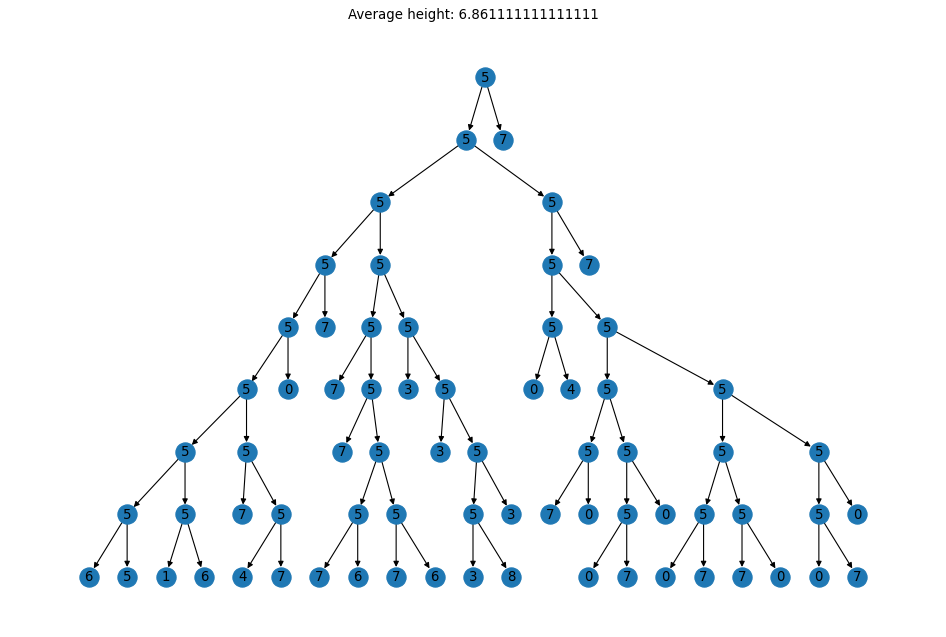

In [20]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [21]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 36


In [22]:
method = 'MLE'

In [23]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [24]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()